In [ ]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import keras
import cv2
from keras.layers import Conv2D,BatchNormalization
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import os
# re-size all the images to this

In [ ]:
#to extract the images from the directory i.e to get the whole data with img_size 224(for VGG) to train our model
img_size = 224
labels = ['COVID','NORMAL','Viral Pneumonia']
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                #VGG is trained on RGB(3 channel) images, so the grayscale is stacked 3 times 
                rgb=np.dstack((resized_arr, resized_arr, resized_arr))
                data.append([rgb,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#getting the overall data
df = get_training_data('../content/COVID-19 Radiography Database')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


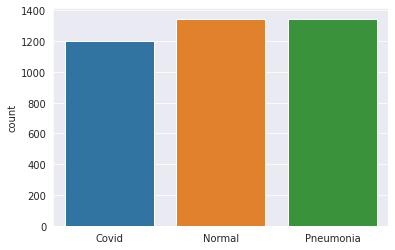

In [ ]:
#A countplot/crosstab to represent the number of radiology reports in each of the categories.
l = []
for i in df:
    if(i[1] == 0):
        l.append("Covid")
    elif(i[1] == 1):
        l.append("Normal")    
    else:
        l.append("Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l)        

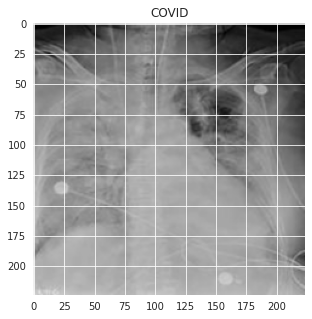

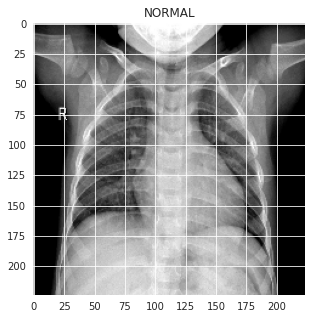

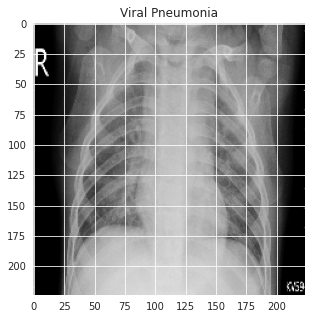

In [ ]:
#plotting images for each of the categories
plt.figure(figsize = (5,5))
plt.imshow(df[0][0])
plt.title(labels[df[0][1]])
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(df[2200][0])
plt.title(labels[df[2000][1]])
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(df[-8][0])
plt.title(labels[df[-1][1]])
plt.show()

In [ ]:
# creating a VGG layer with 3 channels and image size 224
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights becuase vgg 16 has already been trained with millions of images
for layer in vgg.layers:
  vgg.trainable = False


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
 #flatteing the output of vgg16 layer
x = Flatten()(vgg.output)
#Dense layer of 3 in the end for 3 classes
prediction = Dense(3, activation='softmax')(x)

# create a model object which takes the 3 channel images as input and predicts the classes  
vgg_model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
vgg_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#train test split
train,test= train_test_split(df,test_size=.15, random_state=0)
x_train = []
y_train = []
x_test = []
y_test = []


for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
# resize data to give as input to the vgg16 layer 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)
x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)
y_test_copy=y_test

In [ ]:
#So that the dimensionality of labels of our images remain consistent with the input, we do their one hot encoding
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train, 3)
y_test= to_categorical(y_test, 3)

In [ ]:
y_train[0]

array([0., 0., 1.], dtype=float32)

In [ ]:
# fit the model for just 1 iteration
import time
t1=time.time()
history = vgg_model.fit(x_train,y_train,epochs = 1,validation_split=0.1,verbose=1)
t2=time.time()
print('The time taken to train the model is',round(int(t2-t1)/60,2),'minutes')

93/93 [==============================] - 1637s 18s/step - loss: 0.4014 - accuracy: 0.8463 - val_loss: 0.1539 - val_accuracy: 0.9396
The time taken to train the model is 27.32 minutes


In [ ]:
#evaluation of model for test data
a=vgg_model.evaluate(x_test,y_test)
print("Loss of the model is - " , a[0])
print("Accuracy of the model is - " , a[1]*100 , "%")

19/19 [==============================] - 290s 15s/step - loss: 0.1665 - accuracy: 0.9280
Loss of the model is -  0.16649679839611053
Accuracy of the model is -  92.79588460922241 %


In [ ]:
#class prediction for test data
predictions = np.argmax(vgg_model.predict(x_test), axis=-1)
predictions[:15]

array([0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2])

In [ ]:
#display classification report for each of the classes
print(classification_report(y_test_copy, predictions, target_names = ['Covid (Class 0)','Normal (Class 1)','Pneumonia(Class 2)']))

                    precision    recall  f1-score   support

   Covid (Class 0)       0.98      0.99      0.98       187
  Normal (Class 1)       0.99      0.80      0.88       186
Pneumonia(Class 2)       0.85      0.99      0.92       210

          accuracy                           0.93       583
         macro avg       0.94      0.93      0.93       583
      weighted avg       0.94      0.93      0.93       583

